This is my capstone project for the Udacity Machine Learning Nanodegree.

In [1]:
import pandas as pd
import numpy as np
import keras as kr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


Get the data.

In [2]:
directory = 'sandp500/individual_stocks_5yr'
dir_listing = listdir(directory)

In [6]:
symbols_list = []

for symbol in dir_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)

print(len(symbols_list))
print(symbols_list[0])

504
AAL


In [7]:
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[0])

In [8]:
dataset = pd.read_csv(csv_file)

In [9]:
dataset = dataset.assign(trading_date = pd.to_datetime(dataset['Date']))

In [11]:
dataset = dataset.drop('Name', 1)
dataset = dataset.drop('Date', 1)
dataset.set_index(['trading_date'], inplace=True)

In [13]:
display(dataset.head(5))

,Open,High,Low,Close,Volume
trading_date,,,,,
2013-12-09,23.85,25.44,23.45,24.60,43197268
2013-12-10,24.50,25.17,24.41,24.88,18660625
2013-12-11,25.48,27.20,25.37,25.99,38843371
2013-12-12,26.20,26.71,25.45,25.45,19981824
2013-12-13,25.75,26.30,25.52,26.23,12192421


This code is for comparing the different columns of the raw data. 

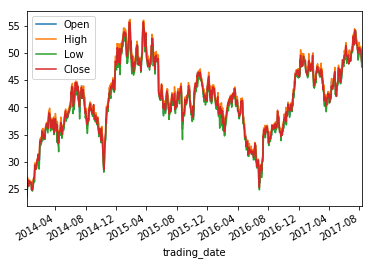

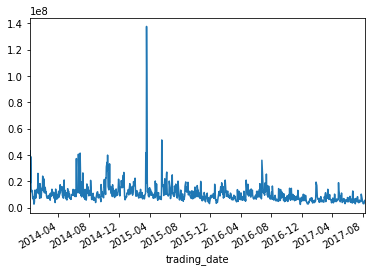

In [14]:
dataset[['Open', 'High', 'Low', 'Close']].plot()
plt.show()
dataset['Volume'].plot()
plt.show()

The following is graphing a few of the graphs with the opening price and the volume on one graph to compare with two different axis'.  I thought to do this as a comparison between the opening price (which all the raw data features follow roughly the same line) and the volume feature.  Since the volume feature is important. [http://www.investopedia.com/terms/v/volume.asp]

In [ ]:
def getting_preprocessed_data(symbol):
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.drop('Name', 1)
        df.set_index('Date', inplace=True)
        # below was found at https://stackoverflow.com/questions/29314033/python-pandas-dataframe-remove-empty-cells
        df['Open'].replace('', np.nan, inplace=True)
        df.dropna(subset=['Open'], inplace=True)
        return df

def plotting_stocks(symbols_list, amount_of_stocks=0):
    if amount_of_stocks == 0:
        amount_of_stocks = len(symbols_list)
        
    for symbol in symbols_list[:amount_of_stocks]:
        fig, ax = plt.subplots()
        fig.subplots_adjust(right=0.7)
        df = getting_preprocessed_data(symbol)
        print(symbol)
        df.Open.plot(ax=ax, style='b-', figsize=(20,10))
        # same ax as above since it's automatically added on the right
        df.Volume.plot(ax=ax, style='r-', secondary_y=True, figsize=(20,10))
        # add legend --> take advantage of pandas providing us access
        # to the line associated with the right part of the axis
        #ax.legend([ax.get_lines()[0], ax.get_lines()[0]], ['Open','Volume'], bbox_to_anchor=(1.5, 0.5))
        plt.show()
        #below is the Daily Returns calculation to put into the Sharpe Ratio. 
        df_preprocessed = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

        #Below is the calculation for the Sharpe Ratio column. 
        df_preprocessed = df_preprocessed.assign(Sharpe_Ratio = np.divide((df_preprocessed.Daily_Returns - 0.046), np.std(np.array([df_preprocessed.Open, df_preprocessed.High, df_preprocessed.Low, df_preprocessed.Close]))))

        #Below is the rate of change (momentum) for the specific stock. 
        df_preprocessed = df_preprocessed.assign(Rate_of_Change = (np.divide(df_preprocessed.Close, df_preprocessed.Open) - 1) * 100)

        #df.plot.scatter(x='Open', y='Volume', label="AAL")
        log_df = np.log(df)
        log_df.plot.scatter(x='Volume', y='Open', label="AAL", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Open', y='Sharpe_Ratio', label="Sharpe Ratio Open", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Volume',y='Sharpe_Ratio', label="Sharpe Ratio Close", figsize=(20,10), use_index=True)
        plt.show()

In [ ]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
plotting_stocks(symbols_list, 1)

In [ ]:
#below is the Daily Returns calculation to put into the Sharpe Ratio. 
dataset_preprocessed = dataset.assign(Daily_Returns = np.divide((dataset.Open - dataset.Close), dataset.Close) * 100)

In [ ]:
#Below is the calculation for the Sharpe Ratio column. 
dataset_preprocessed = dataset_preprocessed.assign(Sharpe_Ratio = np.divide((dataset_preprocessed.Daily_Returns - 0.046), np.std(np.array([dataset_preprocessed.Open, dataset_preprocessed.High, dataset_preprocessed.Low, dataset_preprocessed.Close]), ddof=1)))

In [ ]:
#Below is the rate of change for the specific stock. 
dataset_preprocessed = dataset_preprocessed.assign(Rate_of_Change = (np.divide(dataset_preprocessed.Close, dataset_preprocessed.Open) - 1) * 100)

In [ ]:
dataset_preprocessed.plot.scatter(x='Volume', y='Sharpe_Ratio', label="AAL", figsize=(20,10))
plt.show()

In [ ]:
from IPython.display import display
display(dataset_preprocessed.head(n=1))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error


In [ ]:
# I am using some of the techniques I learned from previous projects.  The below is from the Finding Donors Project. 
# Label encoder example from https://stackoverflow.com/questions/41925157/logisticregression-unknown-label-type-continuous-using-sklearn-in-python
lab_enc = LabelEncoder()
closing = lab_enc.fit_transform(dataset_preprocessed['Close'])
features = dataset_preprocessed.drop('Close', axis = 1)
#features = lab_enc.fit_transform(features)

#closing_raw
#features_raw

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, closing, test_size=0.2, random_state=0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

In [ ]:
clf = SVC()
learner = clf.fit(X_train, y_train)

In [ ]:
pred = clf.predict(X_test)

# This next section will be the creation of the RNN-LSTM model. 

Some information gathered from https://machinelearningmastery.com

From my research and many hours of trial and error I have discovered that the preprocessing needs to be different for the RNN-LSTM as compared to the SVC.  https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Data preprocessing for the RNN-LSTM model

In [ ]:
#from machinelearningmastery.com
dataset = dataset_preprocessed.values
dataset = dataset.astype('float32')

print(dataset_preprocessed.shape)

In [ ]:
training_set = int(len(dataset) * 0.80)
testing_set = len(dataset) - training_set

In [ ]:
X_train_rnn = dataset[0:training_set]
X_test_rnn = dataset[training_set:len(dataset)]

print(X_train_rnn.shape)
print(X_test_rnn.shape)

#X_train = np.reshape(X_train_rnn, (X_train_rnn.shape[0], 1, X_train_rnn.shape[1]))
#X_train = np.reshape(X_train_rnn, (X_train_rnn.shape[0], 64))
#X_test = np.reshape(X_test_rnn, (X_test_rnn.shape[0], 1, X_test_rnn.shape[1]))

In [ ]:
rnn_model = Sequential()
rnn_model.add(LSTM(64, batch_input_shape=(len(X_train), 1, 8)))
rnn_model.summary()

In [ ]:
rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(X_train.shape)
print(rnn_model.input)

In [ ]:
rnn_model.fit(X_train, y_train, epochs=100)

Resource used: https://www.kaggle.com/kwrjcr/predict-stock-prices-with-lstm/editnb

One of my major issues was I was treating the RNN like the rest of the techniques and models I have learned.  I didn't realize that I needed to think of it as a separate model, with its own needs and quarks.  Special thanks to Jason Brownlee of MachineLearningMastery.com for creating a great resource. 